In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import moleculetools as mt
import seaborn as sns
import plot_utils as pu

%matplotlib inline

pu.set_styles()

# Sulflower stability

In [2]:
edf = pd.read_csv("/Users/oscar/Dropbox/s3/flowers/sulflower-stabilities/TABLE", delim_whitespace=True)
s2 = -644366.6164356
s3 = -941921.1454330
edf['n'] = [5, 6, 7, 8, 9, 10, 11, 12]
edf['corrected_scf'] = (edf['scf_energy'] + edf['n']*s2 - edf['n']*s3)/edf['n']
edf

,file,scf_energy,scf_zpve,enthalpy,ts,free_energy,n,corrected_scf
0,s05,-1.487611e+06,-1.487569e+06,-1.487562e+06,30.413498,-1.487592e+06,5,32.313626
1,s06,-1.785226e+06,-1.785174e+06,-1.785165e+06,33.293766,-1.785199e+06,6,16.875129
2,s07,-2.082821e+06,-2.082760e+06,-2.082750e+06,35.991429,-2.082786e+06,7,8.606766
3,s08,-2.380426e+06,-2.380356e+06,-2.380344e+06,39.693734,-2.380384e+06,8,1.234533
4,s09,-2.677983e+06,-2.677904e+06,-2.677891e+06,43.242927,-2.677934e+06,9,0.854727
5,s10,-2.975500e+06,-2.975413e+06,-2.975399e+06,45.791243,-2.975445e+06,10,4.538305
6,s11,-3.273012e+06,-3.272916e+06,-3.272901e+06,48.507103,-3.272949e+06,11,7.964754
7,s12,-3.570541e+06,-3.570436e+06,-3.570419e+06,51.980995,-3.570471e+06,12,9.480093


No handles with labels found to put in legend.


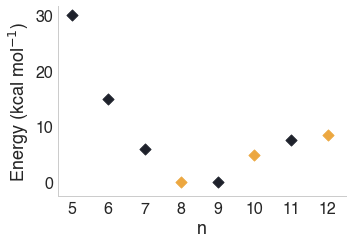

In [3]:
n0 = [5, 6, 7, 9, 11]
energies0 = [30, 15, 6, 0, 7.5]

n1 = [8, 10, 12]
energies1 = [0, 4.8, 8.5]

f, ax = pu.new_figure(height=3.5, type='margin')

sns.scatterplot(x=n0, y=energies0, color=pu.colors['color1'], marker='D', edgecolor=None, ax=ax)
sns.scatterplot(x=n1, y=energies1, color=pu.colors['color8'], marker='D', edgecolor=None, ax=ax)

ax.set_yticks([0, 10, 20, 30])
ax.set_xticks(range(5, 13))
ax.set_xlabel('n')
ax.set_ylabel(r'Energy (kcal mol$^{-1}$)')
pu.tuftefy(ax)

pu.save_figure(f, 'sulflower-strain.pdf')

# Stability study

In [4]:
edf = pd.read_csv("/Users/oscar/Dropbox/s3/flowers/stabilities/TABLE", delim_whitespace=True)
edf.head()

,file,scf_energy,scf_zpve,enthalpy,ts,free_energy
0,as-2,-2.950504e+06,-2.950456e+06,-2.950451e+06,25.711570,-2.950477e+06
1,as-3,-4.401145e+06,-4.401088e+06,-4.401081e+06,31.059832,-4.401113e+06
2,as-ring,-1.499876e+06,-1.499835e+06,-1.499831e+06,21.760143,-1.499853e+06
3,as,-1.402793e+06,-1.402793e+06,-1.402792e+06,11.995470,-1.402804e+06
4,as08,-1.160505e+07,-1.160499e+07,-1.160498e+07,46.770785,-1.160502e+07


In [5]:
scf_table = edf[edf['file'].str.contains('^[a-z]{1,3}[0-9]{2}$', regex=True)].loc[:, ['file', 'scf_energy']]
scf_table['rel_energy'] = scf_table['scf_energy'] - scf_table['scf_energy'].min()
scf_table

,file,scf_energy,rel_energy
4,as08,-1.160505e+07,7.050041e+06
5,as10,-1.450628e+07,4.148815e+06
6,as12,-1.740752e+07,1.247579e+06
10,asn08,-1.168866e+07,6.966433e+06
11,asn10,-1.461074e+07,4.044352e+06
12,asn12,-1.753288e+07,1.122218e+06
21,p08,-2.095109e+06,1.655999e+07
22,p10,-2.618877e+06,1.603622e+07
23,p12,-3.142609e+06,1.551249e+07
27,pn08,-2.178708e+06,1.647639e+07


{'S': array([1.23453302, 4.5383049 , 9.48009298]), 'Se': array([ 0.586415  ,  9.014788  , 10.67370167]), 'As': array([ 9.56115275, 13.268442  , 14.90299567]), 'AsN': array([ 3.14328125, 11.584012  , 12.8329025 ]), 'P': array([3.51396812, 4.4820329 , 8.10146567]), 'PN': array([ 8.68472003, 13.6736681 , 18.04769665])}


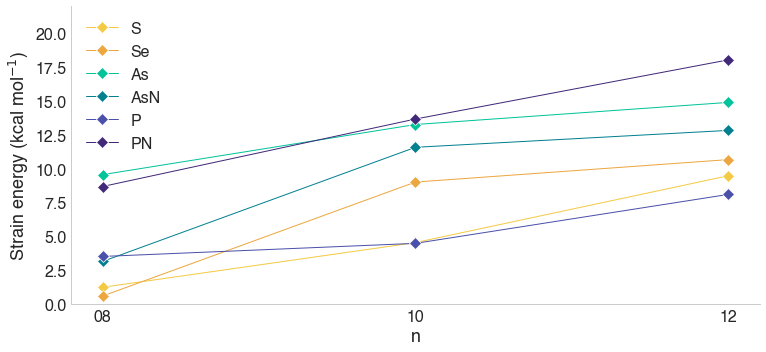

In [6]:
zero = np.zeros(3)

energies = {
    'S':zero,
    'Se':zero,
    'As':zero,
    'AsN':zero,
    'P':zero,
    'PN':zero
}

for key in energies.keys():
    regex_string = '^{system}[0-9]{{2}}$'.format(system=key.lower())
    energies[key] = edf[edf['file'].str.contains(regex_string, regex=True)]['scf_energy'].to_numpy()
    nl2 = edf[edf['file'].str.contains('^{system}-2$'.format(system=key.lower()), regex=True)]['scf_energy'].to_numpy()
    nl3 = edf[edf['file'].str.contains('^{system}-3$'.format(system=key.lower()), regex=True)]['scf_energy'].to_numpy()
    for i, n in enumerate([8, 10, 12]):
        energies[key][i] = (energies[key][i] + n*nl2 - n*nl3)/n

min_energy = 0#sorted(sum([list(value) for value in energies.values()], []))[0]

print(energies)

x = [1, 2, 3]
f, ax = pu.new_figure(height=5, type='body')

for family in energies.keys():
    sns.lineplot(x=x, y=energies[family] - min_energy, color=pu.sys_colors[family.lower()],
                      label=family, marker='D', ax=ax)

ax.set_ylim([0, 22])
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['08', '10', '12'])
ax.set_xlabel('n')
ax.set_ylabel(r'Strain energy (kcal mol$^{-1}$)')
pu.tuftefy(ax)

pu.save_figure(f, 'sunflower-stability.pdf')

# Counterpoise energy plot

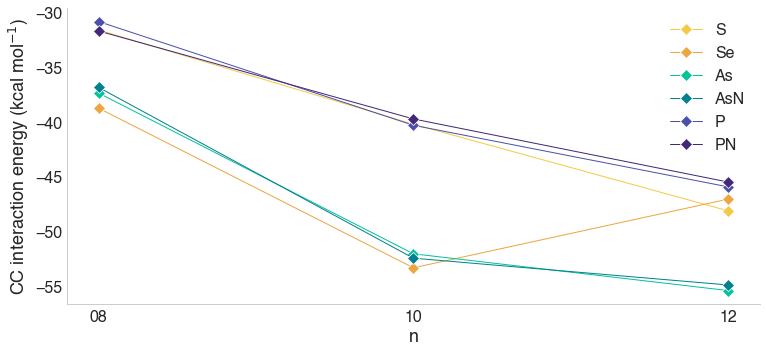

In [7]:
energies = {
    'S':[-31.61, -40.22, -48.14],
    'Se':[-38.76, -53.35, -47.07],
    'As':[-37.38, -52.07, -55.43],
    'AsN':[-36.86, -52.47, -54.92],
    'P':[-30.84, -40.32, -45.95],
    'PN':[-31.70, -39.74, -45.51]
}

#for k, v in energies.items():
#    for i, n in enumerate([8, 10, 12]):
#        v[i] = v[i]/n

x = [1, 2, 3]
f, ax = pu.new_figure(height=5, type='body')

for k, v in energies.items():
    sns.lineplot(x=x, y=v, color=pu.sys_colors[k.lower()],
                      label=k, marker='D', ax=ax)

ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['08', '10', '12'])
ax.set_xlabel('n')
ax.set_ylabel(r'CC interaction energy (kcal mol$^{-1}$)')
pu.tuftefy(ax)

pu.save_figure(f, 'counterpoise-energies.pdf')

# Bond length study

In [8]:
bond_path = "/Users/oscar/Dropbox/s3/flowers/bond-lengths/"

def get_atom_categories(mol_id):
    """
    Identifies the category of each atom in a sulflower structure, dividing them in:
    - X0 atom in the inside ring
    - X1: outside heteroatom
    - X2: atom between two X1 and an X0
    """
    els, coords = mt.read_xyz(bond_path + mol_id + '.xyz')
    structure = mt.Structure(els, coords)
    structure.find_bonds()
    
    atom_list = list(range(structure.natoms))
    atom_categories = {}
    
    # Identify atoms that are bonded to only 2 other atoms: these are X1
    atom_occurrences = [bond['atoms'] for bond in structure.bonds]
    atom_occurrences = list(sum(atom_occurrences, ()))
    
    for atom in range(structure.natoms):
        appearances = atom_occurrences.count(atom)
        if appearances == 2:
            atom_categories[atom] = 'X1'
            atom_list.remove(atom)
        else:
            atom_categories[atom] = None
        
    # Identify which of the remaining atoms are bonded to X1 atoms
    x1_atoms = [atom for atom in atom_categories.keys() if atom_categories[atom] == 'X1']
    for atom in atom_list:
        bonded_atoms = [bond['atoms'] for bond in structure.bonds if atom in bond['atoms']]
        bonded_atoms = set(sum(bonded_atoms, ()))
        if any(atom in x1_atoms for atom in bonded_atoms):
            atom_categories[atom] = 'X2'
        else:
            atom_categories[atom] = 'X0'
        
    return atom_categories

def get_bond_df(mol_id):
    """
    Identifies the category of each bond in a sulflower structure:
    - O: outside bond between an X1 and an X2
    - M: middle bond between an X0 and an X1
    - I: inside bond between X0s
    """
    els, coords = mt.read_xyz(bond_path + mol_id + '.xyz')
    structure = mt.Structure(els, coords)
    structure.find_bonds()
    bond_types = {}
    for bond in structure.bonds:
        bond_types.setdefault(bond['elements'], []).append(bond)
    df = pd.DataFrame(structure.bonds)
    
    cats = get_atom_categories(mol_id)
    df['atom_types'] = df['atoms'].apply(lambda pair:(cats[pair[0]], cats[pair[1]]))
    bond_type_dict = {('X0', 'X0'):'I', ('X0', 'X2'):'M', ('X1', 'X2'):'O'}
    df['bond_types'] = df['atom_types'].apply(lambda atom_types:bond_type_dict[tuple(sorted(atom_types))])
    
    return df

def get_bond_stats(mol_id):
    df = get_bond_df(mol_id)
    df = df[df['elements'] != ('C', 'H')] # Quick fix to prevent bonds with H in rings
    means = df.groupby('bond_types').mean()
    stds = df.groupby('bond_types').std()
    tuple_list = list(zip(means['distance'], stds['distance']))
    distance_list = list(sum(tuple_list, ()))
    rounded_list = [np.around(x, 3) for x in distance_list]
    return rounded_list

def get_system_stats(sys_id):
    n_petals = ['ring', '08', '10', '12']
    mols = [x.format(sys_id) for x in ['{}-ring', '{}08', '{}10', '{}12']]
    for i, mol in enumerate(mols):
        line = "& {} & {:.3f} & {:.3f} & {:.3f} & {:.3f} & {:.3f} & {:.3f} \\\\".format(n_petals[i], *get_bond_stats(mol))
        print(line)
    
get_system_stats('p')

& ring & 1.467 & nan & 1.359 & 0.000 & 1.794 & 0.001 \\
& 08 & 1.410 & 0.048 & 1.445 & 0.000 & 1.764 & 0.006 \\
& 10 & 1.431 & 0.000 & 1.471 & 0.000 & 1.736 & 0.000 \\
& 12 & 1.429 & 0.045 & 1.462 & 0.002 & 1.747 & 0.005 \\


No handles with labels found to put in legend.


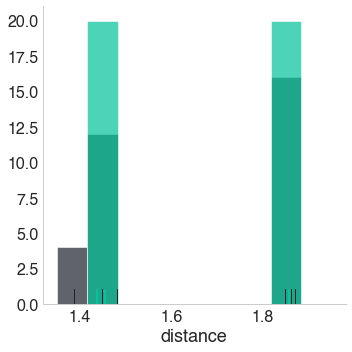

In [9]:
bonds08 = get_bond_df('as08')
bonds10 = get_bond_df('as10')

bins = np.linspace(1.35, 1.95, 10)
alpha = 0.7

f, ax = pu.new_figure(height=5, type='margin')
sns.distplot(a=bonds08['distance'], bins=bins, color=pu.colors['color1'], kde=False, rug=True, hist=True, hist_kws=dict(alpha=alpha), ax=ax)
sns.distplot(a=bonds10['distance'], bins=bins, color=pu.colors['color5'], kde=False, rug=True, hist=True, hist_kws=dict(alpha=alpha), ax=ax)
#ax = sns.distplot(a=bonds['distance'][bonds['elements'] == ('C', 'C')], bins=5, color=colors['black'], kde=True, rug=True, hist=False)
#ax = sns.distplot(a=bonds['distance'][bonds['elements'] == ('C', 'As')], bins=5, color=colors['l_orange'], kde=True, rug=True, hist=False)
pu.tuftefy(ax)

pu.save_figure(f, 'hist-test.pdf')

In [10]:
def distplot_with_hue(data=None, x=None, hue=None, row=None, col=None, legend=True, **kwargs):
    _, bins = np.histogram(data[x].dropna())
    g = sns.FacetGrid(data, hue=hue, row=row, col=col)
    g.map(sns.distplot, x, **kwargs)
    if legend and (hue is not None) and (hue not in [x, row, col]):
        g.add_legend(title=hue) 